<a href="https://colab.research.google.com/github/ShahdTarek/Feature-selection-on-Genome/blob/main/Feature_selection_on_Genome.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Uploading Dataset from Kaggle

In [ ]:
!pip install --upgrade category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 72 kB 824 kB/s 


In [ ]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import files
files.upload()

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d zusmani/mygenome

 16% 5.00M/31.3M [00:00<00:01, 16.2MB/s]
100% 31.3M/31.3M [00:00<00:00, 79.2MB/s]


In [ ]:
from google.colab import files
files.upload()

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle2.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle2.json

In [ ]:
!kaggle datasets download -d ridamahmood005/600-notable-genotypes-by-snpedia

  0% 0.00/22.6k [00:00<?, ?B/s]
100% 22.6k/22.6k [00:00<00:00, 15.6MB/s]


In [ ]:
!ls

600-notable-genotypes-by-snpedia.zip  kaggle.json   sample_data
kaggle2.json			      mygenome.zip


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('mygenome.zip', 'r')
zip_ref.extractall('files')
zip_ref.close()

In [ ]:
zip_ref = zipfile.ZipFile('600-notable-genotypes-by-snpedia.zip', 'r')
zip_ref.extractall('files')
zip_ref.close()


# Data Preprocessing

In [ ]:
import pandas as pd                                                             #mathematical library
import numpy as np                                                              #data manipulation
import seaborn as sns
import matplotlib.pyplot as plt
import random
from sklearn.utils import shuffle
from category_encoders import CountEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss , accuracy_score, precision_score, recall_score



In [ ]:
Genome = pd.read_csv("/content/files/genome_zeeshan_usmani.csv", low_memory=False)
snp = pd.read_excel("/content/files/600 notable genotypes SNPedia.csv.xlsx")

In [ ]:
Genome.head(7)

# Each line corresponds to a single SNP. For each SNP, we provide its identifier
# rsid or an internal id : its location on the reference human genome.
# genotype oriented with respect to the plus strand on the human reference sequence.
# SNP : Single Nucleotide Polymorphism

,# rsid,chromosome,position,genotype
0,rs12564807,1,734462,AA
1,rs3131972,1,752721,AG
2,rs148828841,1,760998,AC
3,rs12124819,1,776546,AA
4,rs115093905,1,787173,GG
5,rs11240777,1,798959,GG
6,rs7538305,1,824398,AA


In [ ]:
Genome.rename(columns={'# rsid':'rsid'}, inplace=True)

In [ ]:
snp.rename(columns={'Unnamed: 0':'rsid'}, inplace=True)
snp.head()

,rsid,Magnitude,Repute,Summary
0,Rs661(A;A),9.0,Bad,early onset Alzheimer's disease
1,Rs6647(T;T),0.0,Good,Normal; two copies of Pi-M1V allele
2,Rs6647(C;C),0.0,Good,Normal; two copies of Pi-M1A allele
3,Rs1303(T;T),0.0,Good,common in clinvar
4,Rs28929471(G;G),0.0,Good,common in complete genomics


In [ ]:
pd.isnull(snp).sum()

rsid          0
Magnitude     0
Repute       43
Summary      28
dtype: int64

In [ ]:
snp = snp.fillna(0)

In [ ]:
snp["genotype"] = snp["rsid"].str.extract('.*\((.*)\).*')                       #to make new column "genotype"
snp["genotype"] = snp["genotype"].str.replace(";","")                           #exclude ; from values of 'genotype'
snp["rsid"] = snp['rsid'].str.replace("\((.*)\)","")                            #removing extra values from column 'rsid'
snp["rsid"] = snp["rsid"].str.lower()
snp.head()

<ipython-input-408-eaabece7e877>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  snp["rsid"] = snp['rsid'].str.replace("\((.*)\)","")                            #removing extra values from column 'rsid'


,rsid,Magnitude,Repute,Summary,genotype
0,rs661,9.0,Bad,early onset Alzheimer's disease,AA
1,rs6647,0.0,Good,Normal; two copies of Pi-M1V allele,TT
2,rs6647,0.0,Good,Normal; two copies of Pi-M1A allele,CC
3,rs1303,0.0,Good,common in clinvar,TT
4,rs28929471,0.0,Good,common in complete genomics,GG


In [ ]:
Genome_with_snp=pd.merge(snp,Genome, on="rsid", how="left")

In [ ]:
#Genome_with_snp = shuffle(Genome_with_snp)
Genome_with_snp.head()

,rsid,Magnitude,Repute,Summary,genotype_x,chromosome,position,genotype_y
0,rs661,9.0,Bad,early onset Alzheimer's disease,AA,NaN,NaN,NaN
1,rs6647,0.0,Good,Normal; two copies of Pi-M1V allele,TT,14,94847415.0,AA
2,rs6647,0.0,Good,Normal; two copies of Pi-M1A allele,CC,14,94847415.0,AA
3,rs1303,0.0,Good,common in clinvar,TT,14,94844843.0,GT
4,rs28929471,0.0,Good,common in complete genomics,GG,NaN,NaN,NaN


In [ ]:
Genome_with_snp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 600 entries, 0 to 599
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   rsid        600 non-null    object 
 1   Magnitude   600 non-null    float64
 2   Repute      600 non-null    object 
 3   Summary     600 non-null    object 
 4   genotype_x  600 non-null    object 
 5   chromosome  409 non-null    object 
 6   position    409 non-null    float64
 7   genotype_y  409 non-null    object 
dtypes: float64(2), object(6)
memory usage: 42.2+ KB


In [ ]:
Genome_with_snp = Genome_with_snp.dropna()

In [ ]:
#profile = ProfileReport(Genome, title='Genome Profile' html={'style':{'full_width':True}})

In [ ]:
Genome_with_snp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 409 entries, 1 to 595
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   rsid        409 non-null    object 
 1   Magnitude   409 non-null    float64
 2   Repute      409 non-null    object 
 3   Summary     409 non-null    object 
 4   genotype_x  409 non-null    object 
 5   chromosome  409 non-null    object 
 6   position    409 non-null    float64
 7   genotype_y  409 non-null    object 
dtypes: float64(2), object(6)
memory usage: 28.8+ KB


In [ ]:
num_of_chromosome = Genome.groupby("chromosome")["chromosome"].count()
num_of_chromosome

chromosome
1     47742
10    29592
11    29883
12    29068
13    21882
14    19002
15    18660
16    19680
17    19364
18    16646
19    13948
2     46815
20    14730
21     8571
22     9307
3     39186
4     34386
5     34900
6     40965
7     33552
8     30651
9     27010
MT     3287
X     19588
Y      2129
Name: chromosome, dtype: int64

In [ ]:
Genome_with_snp

,rsid,Magnitude,Repute,Summary,genotype_x,chromosome,position,genotype_y
1,rs6647,0.0,Good,Normal; two copies of Pi-M1V allele,TT,14,94847415.0,AA
2,rs6647,0.0,Good,Normal; two copies of Pi-M1A allele,CC,14,94847415.0,AA
3,rs1303,0.0,Good,common in clinvar,TT,14,94844843.0,GT
5,rs28929474,0.0,Good,common in complete genomics,GG,14,94844947.0,CC
6,rs28929474,5.5,Bad,Alpha-1 Antitrypsin Deficiency,AA,14,94844947.0,CC
...,...,...,...,...,...,...,...,...
590,rs28939702,0.0,Good,common in clinvar,CC,16,16248756.0,GG
591,rs28937583,0.0,Good,common in complete genomics,TT,1,35250464.0,TT
592,rs28937584,0.0,Good,common in clinvar,GG,14,81610299.0,GG
594,rs2073711,2.0,Good,Back Pain: lower risk of Lumbar Disc Disease.,TT,15,65494212.0,AG


In [ ]:
df = Genome_with_snp['rsid'].str.split(pat='rs', n = 1 , expand=True)

In [ ]:
Genome_with_snp['rsid'] = df[1]

In [ ]:
Genome_with_snp

,rsid,Magnitude,Repute,Summary,genotype_x,chromosome,position,genotype_y
1,6647,0.0,Good,Normal; two copies of Pi-M1V allele,TT,14,94847415.0,AA
2,6647,0.0,Good,Normal; two copies of Pi-M1A allele,CC,14,94847415.0,AA
3,1303,0.0,Good,common in clinvar,TT,14,94844843.0,GT
5,28929474,0.0,Good,common in complete genomics,GG,14,94844947.0,CC
6,28929474,5.5,Bad,Alpha-1 Antitrypsin Deficiency,AA,14,94844947.0,CC
...,...,...,...,...,...,...,...,...
590,28939702,0.0,Good,common in clinvar,CC,16,16248756.0,GG
591,28937583,0.0,Good,common in complete genomics,TT,1,35250464.0,TT
592,28937584,0.0,Good,common in clinvar,GG,14,81610299.0,GG
594,2073711,2.0,Good,Back Pain: lower risk of Lumbar Disc Disease.,TT,15,65494212.0,AG


#Data Visualization

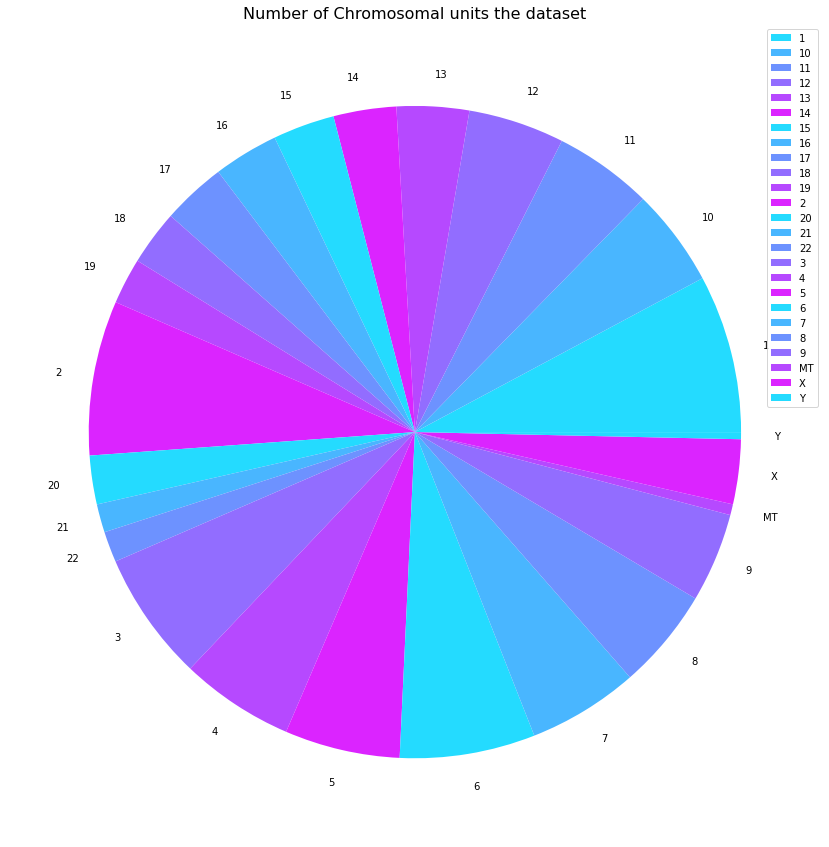

In [ ]:
fig=plt.figure(figsize=(15,15))
colors = sns.color_palette('cool')

plt.pie(num_of_chromosome.values, labels = num_of_chromosome.index, colors=colors)
plt.title("Number of Chromosomal units the dataset", fontsize=16)
plt.legend()                                                                    # creates an area on the graph which describes all the elements of a graph
plt.show()

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


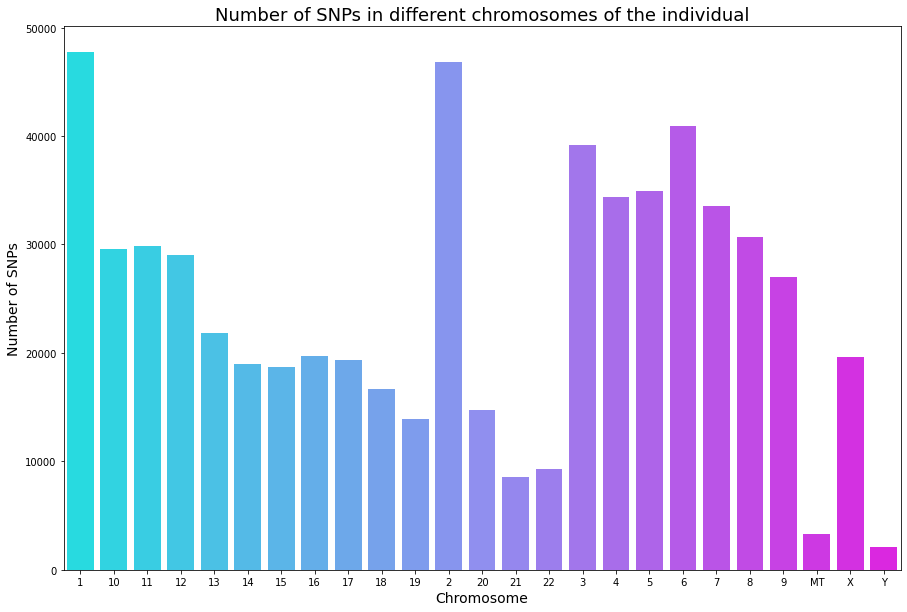

In [ ]:
plt.figure(figsize=(15,10))
sns.barplot(num_of_chromosome.index, num_of_chromosome.values, palette='cool')
plt.title("Number of SNPs in different chromosomes of the individual", fontsize=18)
plt.xlabel("Chromosome", fontsize=14)
plt.ylabel("Number of SNPs", fontsize=14)
plt.show()

#Generating Population

In [ ]:
def GenerateInitialPopulation(Genome_with_snp) :
  initialPopulation = []

  featuresNumbers = np.arange(0, len(Genome_with_snp.columns)-1)                #get numper of features
  for num in featuresNumbers:
    binaryNumber = format(num , "b")                                            #format converts each number to a binary one

    while len(binaryNumber) < 8 :
      binaryNumber = '0' + binaryNumber                                         #add zeros to the number if it is less than 8 bit

    initialPopulation.append(binaryNumber)                                      #now the features binary values is added to population

  return initialPopulation.copy()

#Count Encoding Data

In [ ]:
Genome_with_snp = CountEncoder(cols=['Repute', 'genotype_x', 'chromosome', 'genotype_y']).fit(Genome_with_snp).transform(Genome_with_snp)

In [ ]:
Genome_with_snp = Genome_with_snp.drop('Summary', axis='columns')

In [ ]:
Genome_with_snp

,rsid,Magnitude,Repute,genotype_x,chromosome,position,genotype_y
1,6647,0.0,322,79,38,94847415.0,66
2,6647,0.0,322,111,38,94847415.0,66
3,1303,0.0,322,79,38,94844843.0,2
5,28929474,0.0,322,129,38,94844947.0,102
6,28929474,5.5,60,90,38,94844947.0,102
...,...,...,...,...,...,...,...
590,28939702,0.0,322,111,21,16248756.0,114
591,28937583,0.0,322,79,32,35250464.0,48
592,28937584,0.0,322,129,38,81610299.0,114
594,2073711,2.0,322,79,6,65494212.0,10


#Creating the logistic Regression Model

In [ ]:
def Evaluate(binaryFeatures, Genome_with_snp) :
  map = dict()                                                                  #creating empty map
  featuresStrings = []                                                          #array contains features names

  for FBN in binaryFeatures:
    featureIndex = int(FBN, 2)                                                  #creating index for each feature binary number | 2 is the base of binary numbers
    featureString = list(Genome_with_snp.columns)[featureIndex]                 #list conatains each feature with its index

    featuresStrings.append(featureString)
    map[featureString] = Genome_with_snp[featureString]                         #map[ the way it iterate, the iterated on ]

  x = pd.DataFrame(map)
  y = Genome_with_snp['genotype_x']


  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1       #splitting mapped data
                                                      , random_state=42)
  model = LogisticRegression(penalty="l2" , max_iter=50)                        #penlty used to prevent overfiting of underfiting of data using L2 regularization
  model.fit(x_train, y_train)
  Prediction = model.predict(x_test)


  fitnessValue = accuracy_score(list(y_test), Prediction)                       #calculating the accuracy score for a set of predicted labels against the true labels


  return {"Fitness" : fitnessValue , "Features" : featuresStrings}

In [ ]:
def Stop_if(accuracy):
  if (accuracy > 0.95) :
    return True

  else :
    return False

#Feature Selection

In [ ]:
def SelectFeatures(population):
  ParentsPairsList = []

  for i in range(np.random.randint(1,10)):                                      #randomly select a number of parents between 1 , 10
    parent1 =  random.choice(population)
    parent2 =  random.choice(population)
    ParentsPair = [parent1, parent2]

    ParentsPairsList.append(ParentsPair)                                       #append new pairs of parents each time to the orginal list

  return ParentsPairsList.copy()

#Operations on Parents

In [ ]:
def Operation(ParentsPairsList, Genome_with_snp) :
  newGeneration = []
  num_of_features = len(Genome_with_snp.columns)-1

  for ParentsPair in ParentsPairsList :                                         #loop over each pair of parents to apply crossover then mutate the offsprings
    offsprings = UniformCrossover(ParentsPair[0] , ParentsPair[1])
    mutated_offsprings = FlipBitMutation(offsprings[0], offsprings[1])

    while( int(mutated_offsprings[0],2) > num_of_features-1 or                  #checks if the number of mutated pairs is equal to the number of features
           int(mutated_offsprings[1],2) > num_of_features-1 ):

      offsprings = UniformCrossover(ParentsPair[0], ParentsPair[1])
      mutated_offsprings = FlipBitMutation(offsprings[0], offsprings[1])

    newGeneration.append(mutated_offsprings[0])
    newGeneration.append(mutated_offsprings[1])

  return newGeneration.copy()



def UniformCrossover(parent1 , parent2) :

  Random_mask = [ str(random.randint(0, 1)) for num in range(len(parent1)) ]
  mask = "".join(Random_mask)
  offspring1 = []
  offspring2 = []

  for maskIndex in range(len(mask)):

    if(mask[maskIndex] == '1') :
      offspring1.append( parent1[maskIndex])
      offspring2.append(parent2[maskIndex])

    else :                                                                      # apply a crossover to the other parent if the bit in mask = 0
      offspring1.append(parent2[maskIndex])
      offspring2.append(parent1[maskIndex])

  offspring1 = "".join(offspring1)
  offspring2 = "".join(offspring2)

  return [offspring1, offspring2]




def FlipBitMutation (offspring1, offspring2):

  FlipBitNumber = random.randint(0, len(offspring1)-1)
  offspring1_NumbersList = list(offspring1)
  offspring2_NumbersList = list(offspring2)
                                                                                # flip the offspring bit if 0 -> 1 and if 1 -> 0
  offspring1_NumbersList [FlipBitNumber] = str(int(not bool(int(offspring1_NumbersList [FlipBitNumber]))))
  offspring2_NumbersList [FlipBitNumber] = str(int(not bool(int(offspring2_NumbersList [FlipBitNumber]))))

  Mutated_offspring1 = "".join(offspring1_NumbersList)
  Mutated_offspring2 = "".join(offspring2_NumbersList)

  return [Mutated_offspring1, Mutated_offspring2]

#Update Population

In [ ]:
def UpdatePopulation(newGeneration):

  newPopulation = list(np.unique(newGeneration))                                # getting the uniques of mutated offsprings from the old population to formlate new one
  return newPopulation


#Main

In [ ]:
population = GenerateInitialPopulation(Genome_with_snp)
result = Evaluate(population, Genome_with_snp)
iteration = 0

while(not Stop_if(result["Fitness"])):

  selectedParents = SelectFeatures(population)
  offsprings = Operation(selectedParents, Genome_with_snp)
  population = UpdatePopulation(offsprings)
  result = Evaluate(population, Genome_with_snp)
  iteration+=1

  print(f"{iteration}- Model Accuracy : ", result["Fitness"])
  print(f"     Model Features : ", result["Features"])
  print("___"*35)

BestFeatures = result["Features"]

print("\n\n Best Features are : ", BestFeatures )

1- Model Accuracy :  0.21951219512195122
     Model Features :  ['rsid', 'Magnitude', 'Repute', 'genotype_x', 'chromosome', 'position']
_________________________________________________________________________________________________________
2- Model Accuracy :  0.21951219512195122
     Model Features :  ['rsid', 'Repute', 'chromosome', 'position']
_________________________________________________________________________________________________________
3- Model Accuracy :  0.21951219512195122
     Model Features :  ['rsid', 'Repute', 'position']
_________________________________________________________________________________________________________
4- Model Accuracy :  0.21951219512195122
     Model Features :  ['rsid', 'Magnitude', 'Repute', 'genotype_x', 'chromosome', 'position']
_________________________________________________________________________________________________________
5- Model Accuracy :  0.21951219512195122
     Model Features :  ['rsid', 'Magnitude', 'Repute', 'gen

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

10- Model Accuracy :  0.8536585365853658
     Model Features :  ['Repute', 'genotype_x']
_________________________________________________________________________________________________________
11- Model Accuracy :  0.21951219512195122
     Model Features :  ['rsid', 'Magnitude', 'Repute', 'genotype_x']
_________________________________________________________________________________________________________
12- Model Accuracy :  0.21951219512195122
     Model Features :  ['rsid', 'Magnitude', 'Repute', 'genotype_x', 'position']
_________________________________________________________________________________________________________
13- Model Accuracy :  0.21951219512195122
     Model Features :  ['rsid', 'Magnitude', 'Repute', 'genotype_x', 'chromosome', 'position']
_________________________________________________________________________________________________________
14- Model Accuracy :  0.21951219512195122
     Model Features :  ['rsid', 'genotype_x', 'chromosome']
______________

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


20- Model Accuracy :  0.2682926829268293
     Model Features :  ['Magnitude', 'Repute', 'genotype_x', 'chromosome']
_________________________________________________________________________________________________________
21- Model Accuracy :  0.21951219512195122
     Model Features :  ['rsid', 'Magnitude', 'Repute', 'chromosome', 'position']
_________________________________________________________________________________________________________
22- Model Accuracy :  0.21951219512195122
     Model Features :  ['rsid', 'position']
_________________________________________________________________________________________________________
23- Model Accuracy :  0.21951219512195122
     Model Features :  ['rsid', 'Magnitude', 'Repute', 'chromosome', 'position']
_________________________________________________________________________________________________________
24- Model Accuracy :  0.21951219512195122
     Model Features :  ['rsid', 'Magnitude', 'genotype_x', 'chromosome', 'position']
_

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

51- Model Accuracy :  0.21951219512195122
     Model Features :  ['rsid', 'Magnitude', 'Repute', 'genotype_x', 'chromosome', 'position']
_________________________________________________________________________________________________________
52- Model Accuracy :  0.21951219512195122
     Model Features :  ['rsid', 'chromosome', 'position']
_________________________________________________________________________________________________________
53- Model Accuracy :  0.21951219512195122
     Model Features :  ['rsid', 'Magnitude', 'Repute', 'chromosome', 'position']
_________________________________________________________________________________________________________
54- Model Accuracy :  0.21951219512195122
     Model Features :  ['rsid', 'Magnitude', 'chromosome', 'position']
_________________________________________________________________________________________________________
55- Model Accuracy :  0.21951219512195122
     Model Features :  ['rsid', 'Magnitude', 'chromosome', 'p

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


71- Model Accuracy :  0.21951219512195122
     Model Features :  ['rsid', 'Magnitude', 'Repute', 'genotype_x', 'chromosome', 'position']
_________________________________________________________________________________________________________
72- Model Accuracy :  0.21951219512195122
     Model Features :  ['rsid', 'Magnitude', 'genotype_x', 'chromosome', 'position']
_________________________________________________________________________________________________________
73- Model Accuracy :  0.21951219512195122
     Model Features :  ['chromosome', 'position']
_________________________________________________________________________________________________________
74- Model Accuracy :  0.21951219512195122
     Model Features :  ['rsid', 'Magnitude', 'chromosome', 'position']
_________________________________________________________________________________________________________
75- Model Accuracy :  0.21951219512195122
     Model Features :  ['rsid', 'chromosome']
___________________

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

80- Model Accuracy :  0.21951219512195122
     Model Features :  ['rsid', 'Magnitude', 'Repute', 'genotype_x', 'chromosome', 'position']
_________________________________________________________________________________________________________
81- Model Accuracy :  0.21951219512195122
     Model Features :  ['rsid', 'Magnitude', 'Repute', 'genotype_x', 'chromosome', 'position']
_________________________________________________________________________________________________________
82- Model Accuracy :  0.21951219512195122
     Model Features :  ['rsid', 'Magnitude', 'Repute', 'genotype_x', 'chromosome']
_________________________________________________________________________________________________________
83- Model Accuracy :  0.21951219512195122
     Model Features :  ['rsid', 'Magnitude', 'chromosome']
_________________________________________________________________________________________________________
84- Model Accuracy :  0.21951219512195122
     Model Features :  ['rsid', 'M

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

102- Model Accuracy :  0.7560975609756098
     Model Features :  ['Magnitude', 'genotype_x']
_________________________________________________________________________________________________________
103- Model Accuracy :  0.21951219512195122
     Model Features :  ['rsid', 'Repute', 'genotype_x', 'position']
_________________________________________________________________________________________________________
104- Model Accuracy :  0.24390243902439024
     Model Features :  ['Repute', 'chromosome']
_________________________________________________________________________________________________________
105- Model Accuracy :  0.21951219512195122
     Model Features :  ['rsid', 'Repute', 'genotype_x', 'chromosome', 'position']
_________________________________________________________________________________________________________
106- Model Accuracy :  0.21951219512195122
     Model Features :  ['rsid', 'Magnitude', 'Repute', 'genotype_x', 'chromosome', 'position']
__________________

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

123- Model Accuracy :  0.21951219512195122
     Model Features :  ['Magnitude', 'Repute', 'genotype_x', 'chromosome', 'position']
_________________________________________________________________________________________________________
124- Model Accuracy :  0.21951219512195122
     Model Features :  ['rsid', 'Magnitude', 'Repute', 'genotype_x', 'chromosome', 'position']
_________________________________________________________________________________________________________
125- Model Accuracy :  0.21951219512195122
     Model Features :  ['rsid', 'Magnitude', 'chromosome', 'position']
_________________________________________________________________________________________________________
126- Model Accuracy :  0.21951219512195122
     Model Features :  ['Magnitude', 'chromosome', 'position']
_________________________________________________________________________________________________________
127- Model Accuracy :  0.21951219512195122
     Model Features :  ['rsid', 'Magnitude', 

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

153- Model Accuracy :  0.21951219512195122
     Model Features :  ['rsid', 'Magnitude', 'Repute', 'genotype_x', 'chromosome', 'position']
_________________________________________________________________________________________________________
154- Model Accuracy :  0.21951219512195122
     Model Features :  ['rsid', 'Magnitude', 'Repute', 'genotype_x', 'chromosome', 'position']
_________________________________________________________________________________________________________
155- Model Accuracy :  0.21951219512195122
     Model Features :  ['rsid', 'Magnitude', 'Repute', 'position']
_________________________________________________________________________________________________________
156- Model Accuracy :  0.21951219512195122
     Model Features :  ['rsid', 'Magnitude', 'Repute', 'genotype_x', 'chromosome', 'position']
_________________________________________________________________________________________________________
157- Model Accuracy :  0.21951219512195122
     Mode

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


174- Model Accuracy :  0.21951219512195122
     Model Features :  ['rsid', 'Magnitude', 'Repute', 'genotype_x', 'chromosome', 'position']
_________________________________________________________________________________________________________
175- Model Accuracy :  0.21951219512195122
     Model Features :  ['rsid', 'Magnitude', 'Repute', 'genotype_x', 'chromosome', 'position']
_________________________________________________________________________________________________________
176- Model Accuracy :  0.21951219512195122
     Model Features :  ['rsid', 'Magnitude', 'Repute', 'genotype_x', 'chromosome', 'position']
_________________________________________________________________________________________________________
177- Model Accuracy :  0.21951219512195122
     Model Features :  ['rsid', 'Magnitude', 'Repute', 'chromosome', 'position']
_________________________________________________________________________________________________________
178- Model Accuracy :  0.2195121951219

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che